# A.- Data Prepare

### 1.- Training and test data split.

In [1]:
'''python
Training and test data prepare.
'''

# Libraries needed.

# General purpose.
import pandas as pd
import numpy as np

# To show graphs and charts.
import matplotlib.pyplot as plt
import seaborn as sns

# To split training and test data.
from sklearn.model_selection import train_test_split

# To transform data.
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler

# For feature selection.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


In [2]:
# Loading the data.
df = pd.read_csv('bank_dataset.csv')

# Selecting the features.
X = df.loc [:, df.columns.drop ('deposit')]

# Our target.
Y = df.loc [:, ['deposit']]

# Training and test data split.
Xtrain, Xtest, Ytrain, Ytest = train_test_split (X, Y, test_size = 0.3, random_state = 1, stratify = Y)

# Saving the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv  ('bank_test.csv', index = False)
Ytrain.to_csv ('bank_target_train.csv', index = False)
Ytest.to_csv  ('bank_target_test.csv', index = False)


### 2.- Setting null data.

#### 2.1.- Through the mean and the mode.

Only a few null values are found, placed on the "age", "marital" and "status" columns.

"age" column null data is filled with the mean.

In [3]:
# "age" mean
age_mean = X ['age'].mean ()

# For the training values.
Xtrain.loc [Xtrain ['age'].isnull(), 'age'] = age_mean

# For the test values.
Xtest.loc [Xtest ['age'].isnull(), 'age'] = age_mean

# Saving the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


We fill "marital" and "education" null data with the mode, as a function of age, through the definition of a set of intervals.

In [4]:
# On 'marital' and 'education' columns we fill null data with the mode, as a function of age.

# We define a tuple for diferent intervals on 'age': 0 - 18, 18 - 25, 25 - 45, 45 - 65 and > 65.
tpl_age = (0, 18, 25, 45, 65)

# We compute the mode for every interval and we save it to a list.
def mode_by_age (df, col):
    lst_mode = []

    for i in range (len (tpl_age) - 1):
        # print ("i ", i)
        df_age = df.loc [(df ['age'] > tpl_age [i]) & (df ['age'] <= tpl_age [i + 1]), :]
        # print (df_age)
        if not df_age.empty:
            lst_mode.append (df_age [col].mode () [0])
        else:
            lst_mode.append (-1)

    df_age = df.loc [(df ['age'] > tpl_age [i + 1])]
    if not df_age.empty:
        lst_mode.append (df_age [col].mode () [0])
    else:
        lst_mode.append (-1)

    return lst_mode

# We fill null values with the mode computed above, as a function of age.
def missing_by_age (df, col):

    faltan = df[col].isnull ().sum ()

    if faltan == 0:
        print ("Null values (", col, "): ", faltan)
        # print ("return")
        return
    
    print ("Null values (", col, "): ", faltan)

    lst_mode = mode_by_age (df, col)

    for i in range (len (tpl_age) - 1):
        df.loc [(df ['age'] > tpl_age [i]) & (df ['age'] <= tpl_age [i + 1]), [col]] = df.fillna ({col: lst_mode [i]})

    i += 1
    df.loc [(df ['age'] > tpl_age [i]), [col]] = df.fillna ({col: lst_mode [i]})

    print ("Null values (", col, "): ", df[col].isnull ().sum ())

# We fill null values by calling 'missing_by_age'.

# For training values.
missing_by_age (Xtrain, 'marital')
missing_by_age (Xtrain, 'education')

# For test values.
missing_by_age (Xtest, 'marital')
missing_by_age (Xtest, 'education')


Null values ( marital ):  5
Null values ( marital ):  0
Null values ( education ):  5
Null values ( education ):  0
Null values ( marital ):  0
Null values ( education ):  2
Null values ( education ):  0


#### 2.2.- Through value setting.

In the .csv file appear many rows with the value "other" in the  column "poutcome". We set those values with the 'failure' value.

In [5]:
# In the colmun 'poutcome', 'other' will be substituted by 'failure'.

# For the training values.
Xtrain.loc [Xtrain ['poutcome'] == 'other', 'poutcome'] = 'failure'

# For the test values.
Xtest.loc [Xtest ['poutcome'] == 'other', 'poutcome'] = 'failure'

# We save the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


### 3.- Finding Relevant Features.

Since the training data is selected in an aleatory fashion, the most relevant features must be reassessed on further sections of the document.
Note that nor the training data set nor the test one is modified, we only get the correlation matrix and a series of scores.

#### 3.1.- Correlation Matrix.

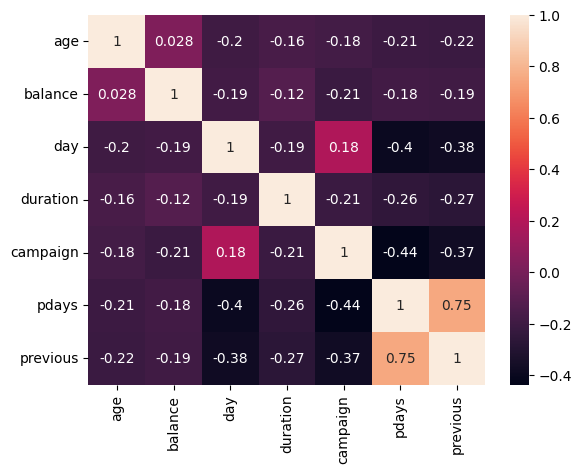

In [6]:
# We create the correlation matrix.

# We load the training data.
Xt_cont = pd.read_csv ('bank_train.csv')

# We select the numeric features.
Xt_cont = Xt_cont.loc [:, ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]

# We create the correlation matrix.
corrM = Xt_cont.corr ()

ax = sns.heatmap (corrM.corr(), annot = True)

In the correlation matrix the features "pdays" and "previous" seem to have an strong correlation, we eliminate "previous".

#### 3.2.- Finding Relevant Numeric Variables.

We compute an "score" for the numeric variable by using ANOVA.

For continuus variables:
Feature 0: 14.922574
Feature 1: 45.996092
Feature 2: 27.126393
Feature 3: 2093.882727
Feature 4: 115.623016
Feature 5: 180.150434
Feature 6: 137.829110


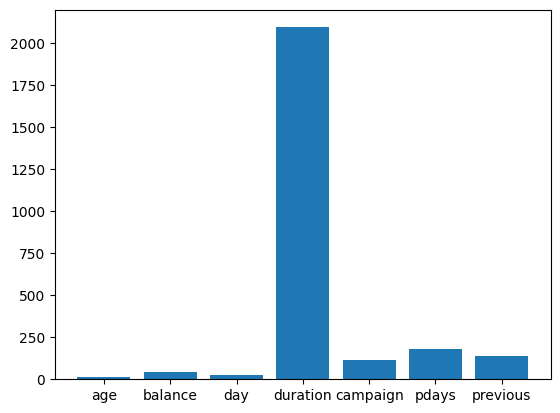

In [7]:
# We first select the continuus variables.

dfX = pd.read_csv('bank_train.csv')
dfY = pd.read_csv('bank_target_train.csv')

# We define the numeric variables.
cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# We select the numeric variables.
dfX = dfX.loc [:, cols]

# The function "SelectKBest" accepts numpy arrays.
np_X = dfX.values
np_Y = dfY.values
np_Y = np.ravel (np_Y, order = 'C')

# We run the ANOVA test.
fs = SelectKBest (score_func = f_classif, k = 'all')
fs.fit (np_X, np_Y)
np_X = fs.transform (np_X)

# We print the score.
print ("For continuus variables:")
for i in range (len (fs.scores_)):
    print ('Feature %d: %f' % (i, fs.scores_[i]))

# We show a histogram.
plt.bar (cols, fs.scores_)
plt.show()

As we can see, the most relevant features are "pdays", "previous" and "campaign". They are followed by "balance", "day" and "age".

Since the duration of the call is not known during the model training, the "duration" variable can't be used as a model feature, in despite showing a strong correlation with "deposit".

Finally, the variable "day" is defined as the "day of the week" in which the contact was done. But its values range from 1 to 31, not from 1 to 7, as we could expect. Even accepting that those were the days of the month, we don't have the year the campaign was made. Thus, we can't match those values to a day of the week. More over, that variable should have little weight on the prediction, as can be checked from the histogram.

#### 3.3.- Finding Relevant Categorical Variables.

We compute an "score" for the categorical variables using the "Chi Squared" test.

For categorical variables:
Feature 0: 60.952777
Feature 1: 8.581278
Feature 2: 32.637642
Feature 3: 7.207927
Feature 4: 175.018119
Feature 5: 70.341760
Feature 6: 622.382214
Feature 7: 8.098994
Feature 8: 64.286790


<BarContainer object of 9 artists>

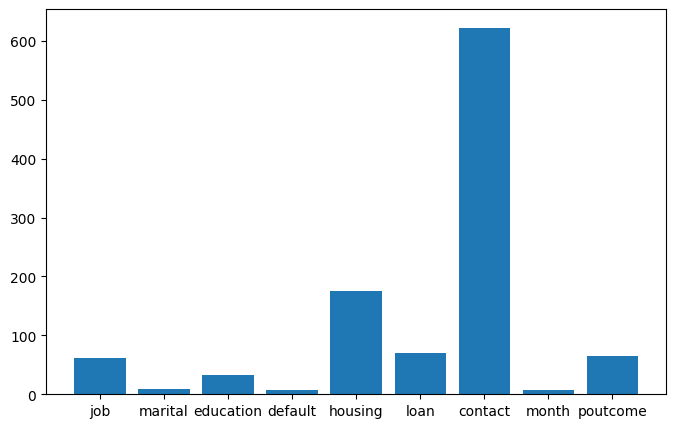

In [8]:
# We select categorical variables.

dfX = pd.read_csv('bank_train.csv')
dfY = pd.read_csv('bank_target_train.csv')

# We define categorical variables.
cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# We change categorical variables to the proper type.
convert_dict = {'job':      'category',
               'marital':   'category',
               'education': 'category',
               'default':   'category',
               'housing':   'category',
               'loan':      'category',
               'contact':   'category',
               'month':     'category',
               'poutcome':  'category'
               }

dfX = dfX.astype (convert_dict)
dfX = dfX.loc [:, cols]

# We set integer values to the features and to the target.
le = LabelEncoder ()
for col in dfX.select_dtypes (include='category').columns:
   dfX [col] = le.fit_transform (dfX [col])

for col in dfY.select_dtypes(include='category').columns:
   dfY [col] = le.fit_transform (dfY [col])

# "SelectKBest" function accepts numpy arrays.
np_X = dfX.values
np_Y = dfY.values
np_Y = np.ravel (np_Y, order = 'C')

# We run the chi squared test.
fs = SelectKBest (score_func = chi2, k = 'all')
fs.fit (np_X, np_Y)
np_X = fs.transform (np_X)

print; print ("For categorical variables:")
for i in range (len (fs.scores_)):
   print ('Feature %d: %f' % (i, fs.scores_[i]))

# We show a histogram with the scores.
plt.figure (figsize = (8, 5))
plt.bar (cols, fs.scores_)


The most relevant features are "contact", "housing", "loan", "poutcome", "job" and "education". Somewaht less relevant are "marital", "default" and "month".

### 4.- Categorical Variables Encoding.

On the last section a "Chi Squared" test was run to the categorical features. The most relevant are "contact", "housing", "loan", "poutcome", "job" and "education". Somewaht less relevant were "marital", "default" and "month". We run "OneHotEncoder" to "job" and "education". On the other side, "contact", "housing", "loan", "poutcome" and "default" are binary variables and we can run "LabelEnconder" on them.

Not to have too may dimensions we discard "marital" and "month", with a low score.

In [9]:
# For the training values.

# We reduce the number of categories for 'job', to avoid rising the number of dimensions.
# It is simpler using the 'object' type.
Xtrain.loc [Xtrain ['job'] == 'housemaid',     ['job']] = 'non-qualified'
Xtrain.loc [Xtrain ['job'] == 'blue-collar',   ['job']] = 'non-qualified'

Xtrain.loc [Xtrain ['job'] == 'admin.',        ['job']] = 'semi-qualified'
Xtrain.loc [Xtrain ['job'] == 'self-employed', ['job']] = 'semi-qualified'
Xtrain.loc [Xtrain ['job'] == 'services',      ['job']] = 'semi-qualified'

Xtrain.loc [Xtrain ['job'] == 'entrepreneur',  ['job']] = 'qualified'
Xtrain.loc [Xtrain ['job'] == 'management',    ['job']] = 'qualified'
Xtrain.loc [Xtrain ['job'] == 'technician',    ['job']] = 'qualified'

# We set the type 'category' to the 'object' columns.
for col in Xtrain.select_dtypes (include='object').columns:
    Xtrain [col] = Xtrain [col].astype ('category')

# We check the number of values of 'job'.
print (Xtrain ['job'].cat.categories)

# Binary columns.
cols = ['contact', 'poutcome', 'housing', 'loan', 'default']

le = LabelEncoder ()
for c in cols:
    Xtrain [c] = le.fit_transform (Xtrain[c])

# Categorical Columns.
Xtrain = pd.get_dummies (Xtrain, columns = ['job', 'education'])

print (Xtrain.info ())
print (Xtrain.loc [:, ['contact', 'poutcome', 'housing', 'loan', 'default']].head ())

# For the test values.

# We reduce the number of categories for 'job', to avoid rising the number of dimensions.
# It is simpler using the 'object' type.
Xtest.loc [Xtest ['job'] == 'housemaid',     ['job']] = 'non-qualified'
Xtest.loc [Xtest ['job'] == 'blue-collar',   ['job']] = 'non-qualified'

Xtest.loc [Xtest ['job'] == 'admin.',        ['job']] = 'semi-qualified'
Xtest.loc [Xtest ['job'] == 'self-employed', ['job']] = 'semi-qualified'
Xtest.loc [Xtest ['job'] == 'services',      ['job']] = 'semi-qualified'

Xtest.loc [Xtest ['job'] == 'entrepreneur',  ['job']] = 'qualified'
Xtest.loc [Xtest ['job'] == 'management',    ['job']] = 'qualified'
Xtest.loc [Xtest ['job'] == 'technician',    ['job']] = 'qualified'

# We set the type 'category' to tyhe 'object' columns.
for col in Xtest.select_dtypes (include='object').columns:
    Xtest [col] = Xtest [col].astype ('category')

# We check the number of values of 'job'.
print (Xtest ['job'].cat.categories)

# Binary colmuns.
# 'cols' is defined above.
le = LabelEncoder ()
for c in cols:
    Xtest [c] = le.fit_transform (Xtest [c])

# Categorical Columns.
Xtest = pd.get_dummies (Xtest, columns = ['job', 'education'])

print (Xtest.info ())
print (Xtest.loc [:, ['contact', 'poutcome', 'housing', 'loan', 'default']].head ())

# We save the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


Index(['non-qualified', 'qualified', 'retired', 'semi-qualified', 'student',
       'unemployed', 'unknown'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 7813 entries, 2681 to 6257
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  7813 non-null   float64 
 1   marital              7813 non-null   category
 2   default              7813 non-null   int64   
 3   balance              7813 non-null   int64   
 4   housing              7813 non-null   int64   
 5   loan                 7813 non-null   int64   
 6   contact              7813 non-null   int64   
 7   day                  7813 non-null   int64   
 8   month                7813 non-null   category
 9   duration             7813 non-null   int64   
 10  campaign             7813 non-null   int64   
 11  pdays                7813 non-null   int64   
 12  previous             7813 non-null   int64  

### 5.- Standardization.

In section 3, the test "ANOVA" was run to the numeric features. The most relevant are "age", "balance", "campaign", "pdays" and "previous". We normalize those varibles. On the other side "pdays" and "previous" seem to be strongly correlated, "previous" will be discarded.

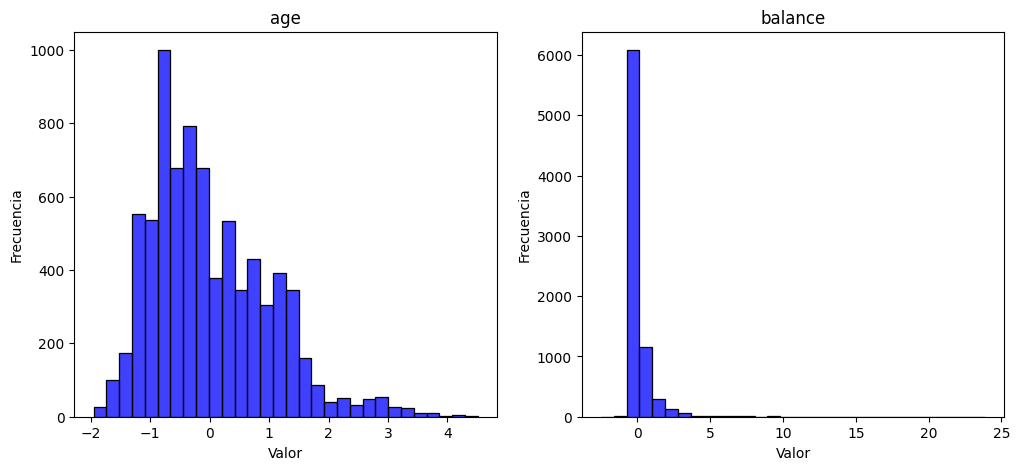

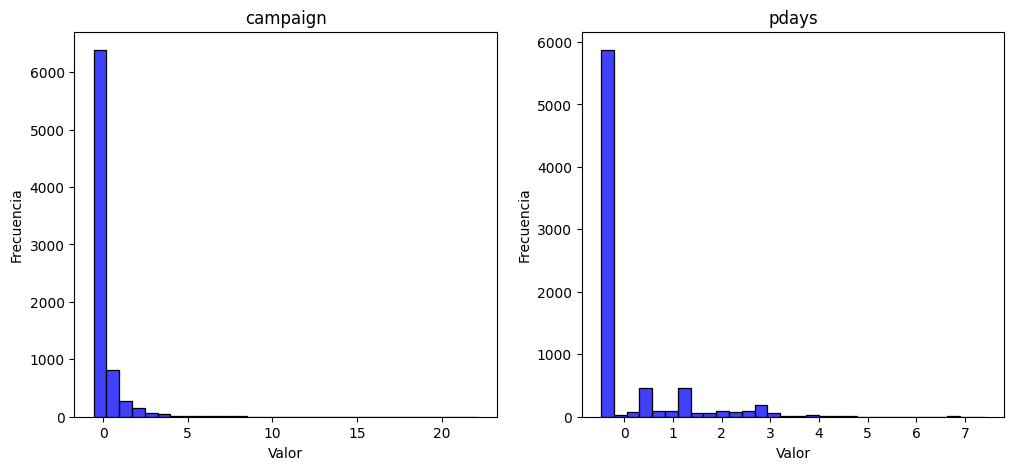

In [10]:
cols = ['age', 'balance', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()

# For the training values.
for c in cols:
    Xtrain [c] = Xtrain [c].astype ('float64')
    Xtrain.loc [:,[c]] = scaler.fit_transform (Xtrain.loc [:,[c]])

# For the test values.
for c in cols:
    Xtest [c] = Xtest [c].astype ('float64')
    Xtest.loc [:,[c]] = scaler.fit_transform (Xtest.loc [:,[c]])

# We save the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)

# The histograms are shown to check that the mean is 0.0 and the standard deviation is 1.0.

# Define the columns to show.
cols = ['age', 'balance']

fig, axes = plt.subplots (nrows = 1, ncols = 2, figsize = (12, 5))

# We iterate over each column to create a histogram.
for i, col in enumerate (cols):
    sns.histplot (Xtrain [col], kde = False, ax = axes [i], color = 'blue', bins = 30)
    axes[i].set_title (f'{col}')
    axes[i].set_xlabel ('Valor')
    axes[i].set_ylabel ('Frecuencia')

# We define the columns to show.
cols = ['campaign', 'pdays']
    
fig, axes = plt.subplots (nrows = 1, ncols = 2, figsize = (12, 5))

# We iterate over each column to create a histogram.
for i, col in enumerate (cols):
    sns.histplot (Xtrain [col], kde = False, ax = axes [i], color = 'blue', bins = 30)
    axes[i].set_title (f'{col}')
    axes[i].set_xlabel ('Valor')
    axes[i].set_ylabel ('Frecuencia')
    
plt.show()

# We save the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


### 6.- Selecting Relevant Features.

In the correlation matrix (Secc. 3) the features "pdays" and "previous" seem to have a strong correlation, we remove "previous".

The most relevant continuus features are "pdays", "previous" and "campaign". They are followed, in a lesser measure, by "balance", "day" and "age".

Since we don't know the duration of the call during the prediction, the duration variable can NOT be used as a  model feature, in despite it is showing an strong correlation with "deposit", our target.

Finally, the variable "day" is defined as the "day of the week" in which the contact was done. But its values range from 1 to 31, not from 1 to 7, as we could expect. Even accepting that they were the days of the month, we don't have the year the campaign was made. Thus, we can't match those values to a day of the week. More over, that variable should have little weight on the prediction, as can be checked from the graph, on section 3.2.

The most relevant categorical features are "contact", "housing", "loan", "poutcome", "job" and "education". Somewhat less relevant are "marital", "default" and "month".

Not to rise the number of dimensions too much, we discard  "marital" and "month", with a low score.

In [11]:
# For the training values.

# From the continuus features we remove "day", "duration" and "previous".
Xtrain = Xtrain.loc [:, Xtrain.columns.drop (['day', 'duration', 'previous'])]

# From the categorical features we remove "marital" and 'month'.
Xtrain = Xtrain.loc [:, Xtrain.columns.drop (['marital', 'month'])]

# For the test values.

# From the continuus features we remove "day", "duration" and "previous".
Xtest = Xtest.loc [:, Xtest.columns.drop (['day', 'duration', 'previous'])]

# From the categorical features we remove "marital" and "month".
Xtest = Xtest.loc [:, Xtest.columns.drop (['marital', 'month'])]

print (Xtrain.info ())
print (Xtest.info ())

# We save the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


<class 'pandas.core.frame.DataFrame'>
Index: 7813 entries, 2681 to 6257
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7813 non-null   float64
 1   default              7813 non-null   int64  
 2   balance              7813 non-null   float64
 3   housing              7813 non-null   int64  
 4   loan                 7813 non-null   int64  
 5   contact              7813 non-null   int64  
 6   campaign             7813 non-null   float64
 7   pdays                7813 non-null   float64
 8   poutcome             7813 non-null   int64  
 9   job_non-qualified    7813 non-null   bool   
 10  job_qualified        7813 non-null   bool   
 11  job_retired          7813 non-null   bool   
 12  job_semi-qualified   7813 non-null   bool   
 13  job_student          7813 non-null   bool   
 14  job_unemployed       7813 non-null   bool   
 15  job_unknown          7813 non-null   boo

### 7.- Data Transform.

From the EDA phase, we can check that continuus features do NOT show normal distributions.

"balance" show a strong bias and outliers, it will be winsorized.

In [12]:
# We winsorize "balance".

# For the training values.
Xtrain ['balance'] = winsorize (Xtrain ['balance'], limits = [0.01, 0.1], inplace = True)

# For the test values.
Xtest ['balance'] = winsorize (Xtest ['balance'], limits = [0.01, 0.1], inplace = True)

# We save the data.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f891fb34690>,
 'caps': [<matplotlib.lines.Line2D at 0x7f891fb360d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f891ff8f410>],
 'medians': [<matplotlib.lines.Line2D at 0x7f891fb37490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f891fb37e50>],
 'means': []}

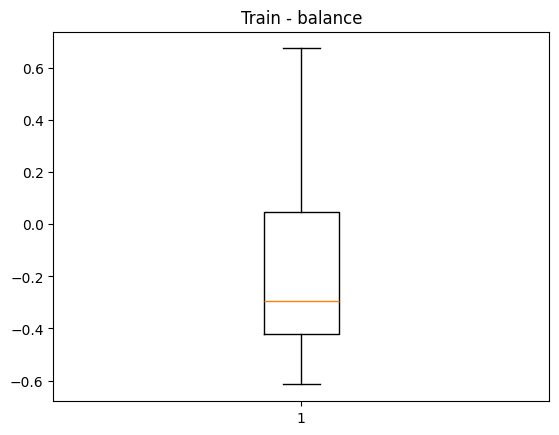

In [13]:
plt.title ("Train - balance")
plt.boxplot (Xtrain ['balance'])

# B.- Model Training.

### 1.- Training.

We wish to know if a customer will open a Certificate of Deposit (CD). So we select a classification model, the logistic regression. This model uses the sigmoid function to compute the probability for a customer to open the CD. To set the value to the target variable, 'diposit', the probability threshold is chosen to 0.5. If the probaility value is greater or equal to 0.5, it gets the value 'yes', or else the value 'no'.

For our matter, false positives, that is positive predictions that did NOT open the CD, will only mean doing more calls. On the contrary false negatives, the negative predicitions that in fact DID OPEN a CD, mean a loss. In other words, false negatives, could mean a loss on the number of CD opened. The number of false negatives must be minimized.

To assess our model the following metrics will be used:

1. Accuracy score.
2. Precision score.
3. Recall score.
4. f1 score.
5. ROC curve.


#### 1.1.- Logistic Regression and Metric Assessment.

In [14]:
'''python
Creation, execution and assessment of the model.
'''

# For the logistic regression.
from sklearn.linear_model import LogisticRegression

# For cross-validation.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# For the scores.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# For the "ROC" curve.
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


Accuracy score:    0.6718423409973127
Precision score:   0.6466346153846154
Recall score:      0.6780088216761184
f1 score:          0.6619501691787142


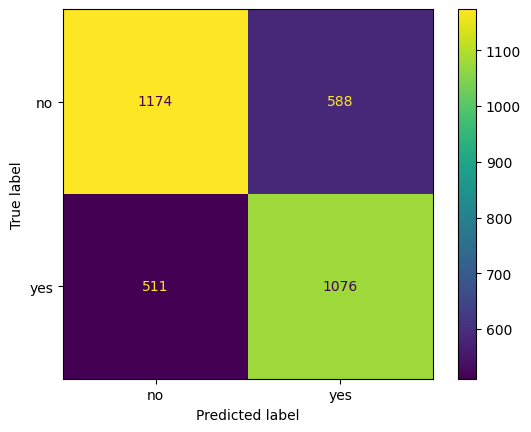

In [15]:

# We load the data.
Xtrain = pd.read_csv ('bank_train.csv')
Xtest  = pd.read_csv ('bank_test.csv')
ytrain = pd.read_csv ('bank_target_train.csv')
ytest  = pd.read_csv ('bank_target_test.csv')

# We choose the model, load the data and train it.
logr0 = LogisticRegression ()
logr0.fit (Xtrain, ytrain.to_numpy ().ravel())

# We run the prediction with test values.
ypred = logr0.predict (Xtest)

# We show the scores.
print ("Accuracy score:   ", accuracy_score   (ytest, ypred))
print ("Precision score:  ", precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ", recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ", f1_score         (ytest, ypred, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

Thresholds:  [       inf 0.90109476 0.88858636 ... 0.0724323  0.07043413 0.00726418]


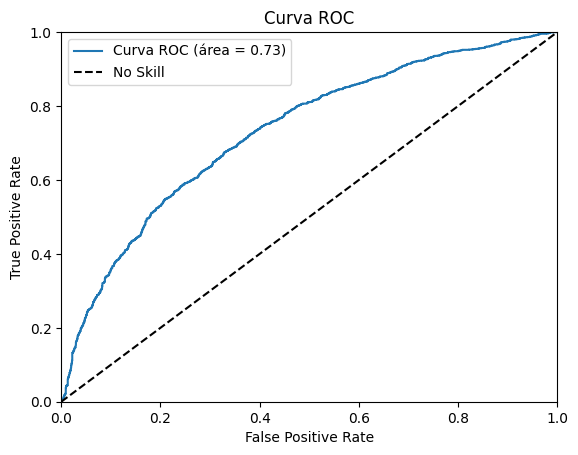

In [16]:
# We plot the ROC curve.

# "logr0" is already defined.
yproba = logr0.predict_proba (Xtest)

# Curve values computation.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc (fpr, tpr)

print ("Thresholds: ", thresholds)

# We plot the curve.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()

1. **Accuracy**:

We get the percentage of correct preditions. It counts true positives (TP) and true negatives (TN) alike.

For our case,

Accuracy = (TP + TN) / N = (1174 + 1076) / 3349 = 0.671 x 100 = 67.2%,

with N = TP + FP + FN + TN = 1174 + 588 + 511 + 1076 = 3349.

N is the number of records, FP are false positives and FN are false negatives.

And so, 67% of customers are correctly classified, no matter if they are positives o negatives.

The figure is reasonable, but it is leaving margin for improvement, however. Below, the tests run to improve the metrics are listed.

2. **Precision**:

It offers the relation between true positives and total positives.

On our case,

Precison = TP / (TP + FP) = 1076 / (1076 + 588) = 0.647 = 64.7%

That is, el 65% of the customers predicted as positives have opened a CD.

3. **Recall**:

This metric is specially interesting for our purposes, since it is sensible to false negatives.

It is defined as the total of true positives (TP) divided by the addition of true positives (TP) plus false negatives (FN):

Recall = TP / (TP + FN) = 1076 / (1076 + 511) = 0.678 = 67.8%

That is, our prediction will detect 68% of all real positives. Real positives are those that, actually, have already opened a CD at the time of testing our model, and so they are part of the test set.

As already explained in the introduction, the negative predictions that actually have opened the CD, mean a loss. In other other words, false negatives, would mean a loss of CDs. The number of false negatives must be minimized.

Optimizing this parameter will lower the number of false negatives. That is, we will avoid discarding calls to customers with real chances to open a CD.

4. **F1**:

This metric is also relevant for our case. It combines 'precision' and 'recall' metrics to get a single ratio. It is defined as:

F = 2·P·R / (P + R)

where, P is 'precision' and R is 'recall'.

We say it is relevant because in our model, if we rise 'recall' by lowering the number of false negatives, we get a lower 'precision'. 'F1 score' ponders both metrics.

For all former metrics, the closer to 1.0, the better.

To improve the above metrics the following test have been run:

1. Column selection.
2. Changing the number of records of training/test.
3. Hyperparameter optimization.
4. Cross-Validation.
5. Change the probability threshold of the model.
6. Check different kinds of models.

The 'ROC' curve will be useful to compare the prediction power of the model before and after of applying the changes.

##### 1.1.1.- **Column Selection.**

Index(['age', 'balance', 'campaign', 'pdays', 'contact', 'default', 'housing',
       'loan', 'poutcome', 'job_non-qualified', 'job_qualified', 'job_retired',
       'job_semi-qualified', 'job_student', 'job_unemployed', 'job_unknown',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown'],
      dtype='object')
Accuracy score:    0.6718423409973127
Precision score:   0.6466346153846154
Recall score:      0.6780088216761184
f1 score:          0.6619501691787142


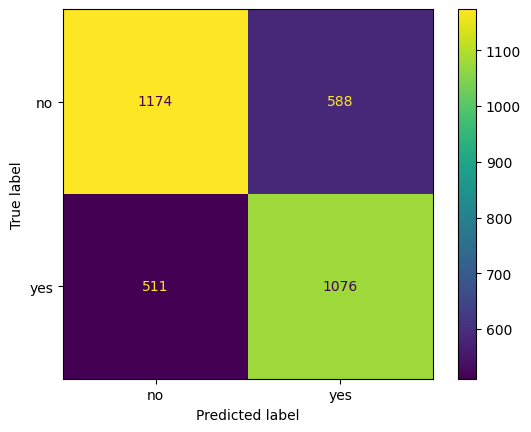

In [17]:

# We load the data.
Xtrain = pd.read_csv ('bank_train.csv')
Xtest  = pd.read_csv ('bank_test.csv')
ytrain = pd.read_csv ('bank_target_train.csv')
ytest  = pd.read_csv ('bank_target_test.csv')

# We choose the columns that improve the prediction of the model.
# Note that if we comment out the lines of the kind "cols.extend (['age'])", by adding "#" to
# the beggining of the line, we can choose the features to train.

# The best results are obtained choosing all relevant columns selected on section 6.

# Continuus columns.
cols = []
cols.extend (['age'])
cols.extend (['balance'])
cols.extend (['campaign'])
cols.extend (['pdays'])

# Categorical Columns.
cols.extend (['contact'])
cols.extend (['default'])
cols.extend (['housing'])
cols.extend (['loan'])
cols.extend (['poutcome'])
cols.extend (['job_non-qualified', 'job_qualified', 'job_retired', 'job_semi-qualified', 'job_student', 'job_unemployed', 'job_unknown'])
cols.extend (['education_primary', 'education_secondary', 'education_tertiary', 'education_unknown'])

Xtrain = Xtrain [cols]
Xtest  = Xtest  [cols]

print (Xtrain.columns)

# We choose the model, we load the data and we train it.
logr = LogisticRegression ()
logr.fit (Xtrain, ytrain.to_numpy ().ravel())

# We make a prediction with the test values.
ypred = logr.predict (Xtest)

# We show the different scores.
print ("Accuracy score:   ", accuracy_score   (ytest, ypred))
print ("Precision score:  ", precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ", recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ", f1_score         (ytest, ypred, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

The best results are obtained choosing all relevant columns selected on section 6.

1.1.2.- **Hyperparameter Optimization.**

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Parámetros óptimos:  LogisticRegression(class_weight='balanced', random_state=10, solver='liblinear')
Accuracy score:    0.668259181845327
Precision score:   0.6312017640573319
Recall score:      0.7214870825456837
f1 score:          0.6733313731255514


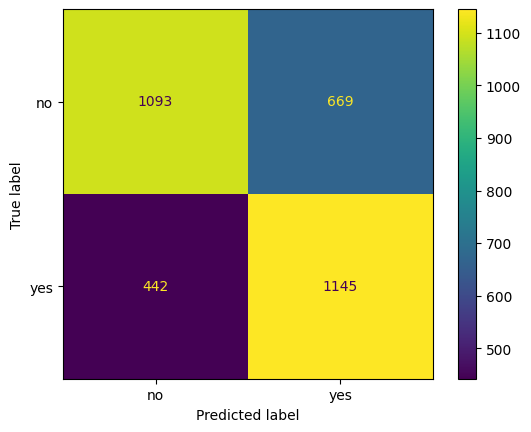

In [18]:
# We optimize the hyperparameters using 'grid search'.

# We include 'max_iter', 'solver' and 'class_weight'
param_grid_lr = {
    'max_iter': [100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],   
    'class_weight': ['balanced']                                    
}

# We configure our grid search for a cross validation for 10 folds.
lr_grid = GridSearchCV (estimator = LogisticRegression (random_state = 10),
                        param_grid = param_grid_lr,
                        verbose = 2, cv = 10, n_jobs = -1)
lr_grid.fit (Xtrain, ytrain.to_numpy ().ravel())

# We get a prediction.
ypred = lr_grid.predict (Xtest)

# We show the optimal parameters.
print ("Parámetros óptimos: ", lr_grid.best_estimator_)

# We show different scores.
print ("Accuracy score:   ", accuracy_score   (ytest, ypred))
print ("Precision score:  ", precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ", recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ", f1_score         (ytest, ypred, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

Using grid search, the number of false negatives has been reduced from 511 a 442. 'recall' has improved while the other scores keep theyr value.

The suggested parameters are:

LogisticRegression(class_weight='balanced', random_state=10, solver='liblinear')

1.1.3.- **Cross-Validation.**

In [19]:
# We define our k-folds, with k = 10, and we shuffle the data.
cv = KFold (n_splits = 10, random_state = 1, shuffle = True)

# We create our model.
lr_K = LogisticRegression (class_weight = 'balanced', random_state = 10, solver = 'newton-cg')

# We redefine the scores to accept the categories '['no', 'yes']'.
precision_sc = make_scorer (precision_score, pos_label = 'yes')
recall_sc    = make_scorer (recall_score, pos_label = 'yes')
f1_sc        = make_scorer (f1_score, pos_label = 'yes')

# We get the scores.
accuracy  = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = 'accuracy', cv = cv, n_jobs = -1)
precision = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = precision_sc, cv = cv, n_jobs = -1)
recall    = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = recall_sc, cv = cv, n_jobs = -1)
f1        = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = f1_sc, cv = cv, n_jobs = -1)

# We show the scores.
print ("Accuracy:\n", accuracy)
print ('Mean (std. dev.):  %.3f (%.3f)' % (np.mean (accuracy),  np.std (accuracy)))

print ("\nPrecision:\n", precision)
print ('Mean (std. dev.): %.3f (%.3f)' % (np.mean (precision), np.std (precision)))

print ("\nRecall:\n", recall)
print ('Mean (std. dev.): %.3f (%.3f)' % (np.mean (recall),    np.std (recall)))

print("\nF1:\n", f1)
print('Mean (std. dev.): %.3f (%.3f)' % (np.mean (f1),        np.std (f1)))


Accuracy:
 [0.64705882 0.65473146 0.65345269 0.63636364 0.63764405 0.65685019
 0.65685019 0.66837388 0.62740077 0.6453265 ]
Mean (std. dev.):  0.648 (0.011)

Precision:
 [0.64164649 0.60152284 0.63681592 0.60144928 0.60655738 0.62467866
 0.60732984 0.61707317 0.61904762 0.61556604]
Mean (std. dev.): 0.617 (0.013)

Recall:
 [0.67430025 0.67714286 0.67191601 0.67663043 0.69251337 0.66575342
 0.66285714 0.71267606 0.66496164 0.696     ]
Mean (std. dev.): 0.679 (0.015)

F1:
 [0.65756824 0.63709677 0.65389527 0.63682864 0.64669164 0.64456233
 0.63387978 0.66143791 0.64118372 0.65331665]
Mean (std. dev.): 0.647 (0.009)


The means keep close to the values we got by using a single training set. The scores dispersion keeps low.

1.1.3.- **Change the Probability Threshold of the Model.**

Accuracy score:    0.6279486413854882
Precision score:   0.5721540414727042
Recall score:      0.8519218651543793
f1 score:          0.6845569620253165


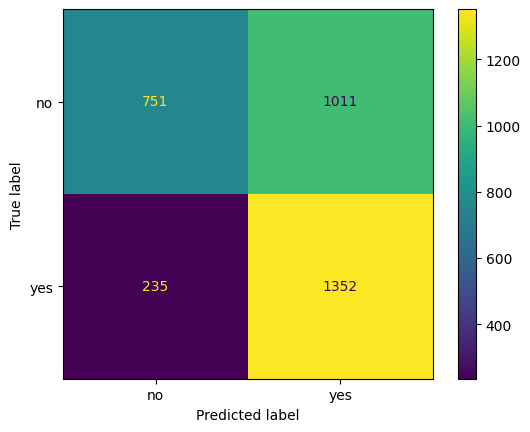

In [20]:
# We change the probability threshold to 0.4, as accepted, to lower the number of false positives.

# We choose the model, we load the data and we train it.
logr = LogisticRegression (class_weight = 'balanced', random_state = 10, solver = 'liblinear')

logr.fit (Xtrain, ytrain.to_numpy ().ravel())

# We get a prediction.
# ypred = logr.predict (Xtest)

# Adjust the prediction to set the threshold to 0.4.
ypred_th = (logr.predict_proba (Xtest)[:, 1] >= 0.40)
ypred_th = np.where (ypred_th, 'yes', 'no')

# We show different scores.
print ("Accuracy score:   ",   accuracy_score  (ytest, ypred_th))
print ("Precision score:  ",   precision_score (ytest, ypred_th, pos_label = 'yes'))
print ("Recall score:     ",   recall_score    (ytest, ypred_th, pos_label = 'yes'))
print ("f1 score:         ",   f1_score        (ytest, ypred_th, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred_th)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

Reducing the probability threshold from 0.5 to 0.4, the number of false negatives is reduced again. Recall improves a whit, precision lowers, but 'f1' keeps its value.

Thresholds:  [       inf 0.90857226 0.89786918 ... 0.08041805 0.07929907 0.00848284]


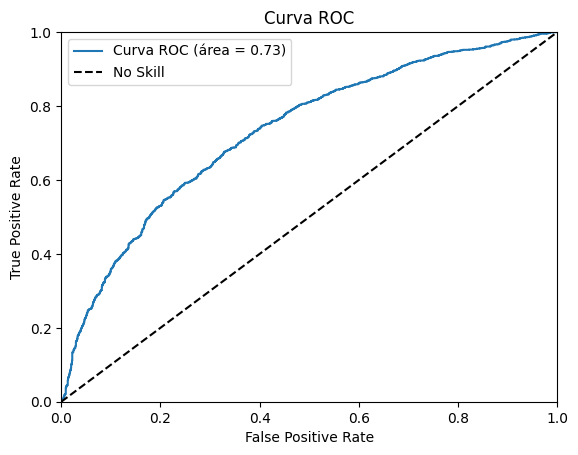

In [21]:
# We plot the ROC curve.

# "logr" already has its parameters configured.
logr.fit (Xtrain, ytrain.to_numpy ().ravel())
yproba = logr.predict_proba (Xtest)

# We compute the values for the curve.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc (fpr, tpr)

print ("Thresholds: ", thresholds)

# We plot the curve.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()

If the 'ROC' curves from sections 1.1 and 1.1.3 are compared it can be checked that the area under the curve, 0.73, hasn't changed. This means that the applied changes do not change the prediction power of the model. The number of false negatives, however, has been lowered.

1.1.4.- **Improvements Applied.**

To improve the metrics the following test have been run:

1. Column selection.

After combining different features, the best combination is obtained by feeding the model with all columns selected on sections 6.

2. Changing the number of records of training/test.

After trying different relations on the number of training/test data, the best relation is 70%/30%. Note that this relation can be changed by updating the parameter 'test_size' of the 'train_test_split' function to 0.2, 0.3, 0.4, ...

That function is found on the section sección 1 at the beginning of the notebook.

3. Hyperparameter optimization.

The function 'GridSearchCV' returns the following hyperparameters as optimal:

"LogisticRegression(class_weight='balanced', random_state=10, solver='liblinear')"

This hyperparameters lower false negatives, going from 511 to 442. That is, we will discard less calls with real chances to open the CD.

4. Cross validation.

A cross-validation with 10 folds shows means similar to the case with a single set of training/test data. Likewise the standard deviation of the scores is relatively small.

5. Change the probability threshold of the model.

Recall that the probabilty threshold is that value of probability from which we predict a positive value. That is, with a probability equal or greater than (e.g.) 0.4 we predict that the customer will open the CD.

If we change the threshold from 0.5 to 0.4 'recall score' significantly improves (to 0.85), at the cost of of reducing 'precision score', as it was anticipated. That means that the false negatives has been reduced. So that, we will discard less calls to customers with real chances to accept the contract.

6. Check different kinds of models.

As an example, in the section '1.3.- Annex. Tests with Different Models' different models of classification and its scores are shown. Some of the models improve by a little those scores. The logistic regression is chosen, however, because the number of false negatives is significantly lower.


#### 1.2.- Conclusions.

In the section 1.1.1 the metrics accuracy, precision, recall and F1, have been defined and applied to our case. During different tests it has been seen that there were room for  improvement, specially recall, that check false negatives. The final metrics are summarized here:

- Accuracy score:    0.628
- Precision score:   0.572
- Recall score:      0.852
- f1 score:          0.685

As we anticipated, improving recall (from 0.678 to 0.852), lowers precision a little (from 0.647 to 0.572). F1, however keeps its value. That means the adopted measures reduce the false negatives, at the same time that the model as a whole keeps its prediction power. That is, the number of calls that are predicted as negatives are reduced, predicted negative, even if those customers had a real probability to accept the CD, which means a gain. The number of positives correctly predicted keeps at 63%. The 'ROC' curves plotted confirm that result.

We highlight the following points from the the test made:

1. All features selected on section 6 are kept.
2. The ratio between the number of training/test data is kept at 70%/30%.
3. Hyperparameter optimization has reduced the number of false negatives.
4. Cross-validation confirms our results.
5. Reducing the probability threshold to 0.4 reduces false negatives.

Finally, the presence of values 'unknown' in the categorical variables like 'job', 'education' and, most of all, 'contact' must be noted. Setting those values during data collection, would improve the different metrics of the model. Data collection is made during the phone calls when the direct marketing campaigns are going on.

#### 1.3.- Annex. Tests with Different Models.

##### 1.3.1.- Gradient Boosting.

Accuracy score:    0.7017020005971932
Precision score:   0.7181008902077152
Recall score:      0.6099558916194077
f1 score:          0.6596252129471891


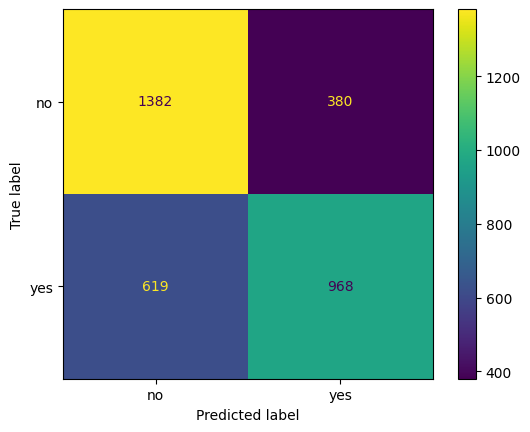

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# We choose our model.
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

gb.fit(Xtrain, ytrain.to_numpy ().ravel())

ypred = gb.predict(Xtest)

# print(classification_report(ytest, ypred))

# We show the scores.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# We plot the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

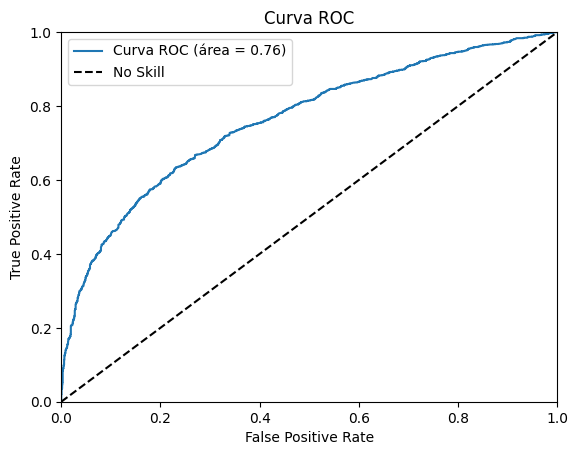

In [23]:
# We plot the ROC curve.

yproba = gb.predict_proba (Xtest)

# We compute the curve values.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc(fpr, tpr)

# We plot the curve.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()


##### 1.3.2.- K-Nearest Neighbors (KNN)

Accuracy score:    0.638996715437444
Precision score:   0.6191677175283733
Recall score:      0.6187775677378702
f1 score:          0.6189725811534825


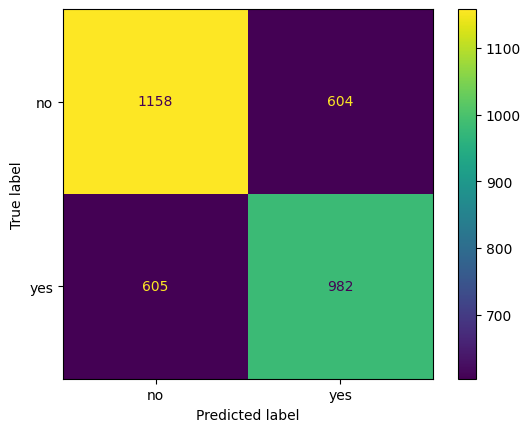

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# We choose the model.
knn = KNeighborsClassifier (n_neighbors = 3)

knn.fit (Xtrain, ytrain.to_numpy ().ravel())

# We get our prediction.
ypred = knn.predict (Xtest)

# Mostramos los 'scores'.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()


##### 1.3.4.- Support Vector Machines (SVM)

Accuracy score:    0.6679605852493281
Precision score:   0.6414532459797498
Recall score:      0.6786389413988658
f1 score:          0.6595223515003061


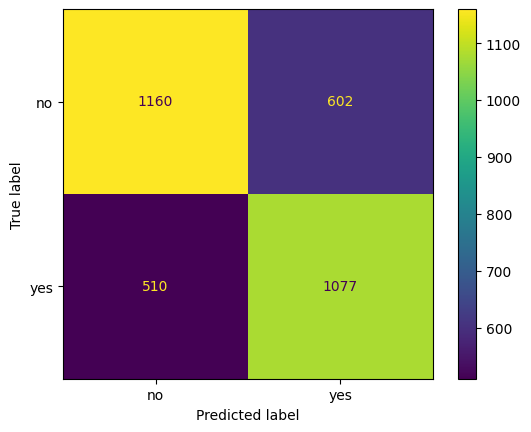

In [25]:
from sklearn.svm import SVC

# We choose the model.
svm = SVC (kernel = 'linear')

svm.fit (Xtrain, ytrain.to_numpy ().ravel())

# We get our prediction.
ypred = svm.predict (Xtest)

# We show the scores.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()


##### 1.3.5. Decision Tree.

Accuracy score:    0.6903553299492385
Precision score:   0.7239413680781759
Recall score:      0.5601764335223692
f1 score:          0.6316163410301954


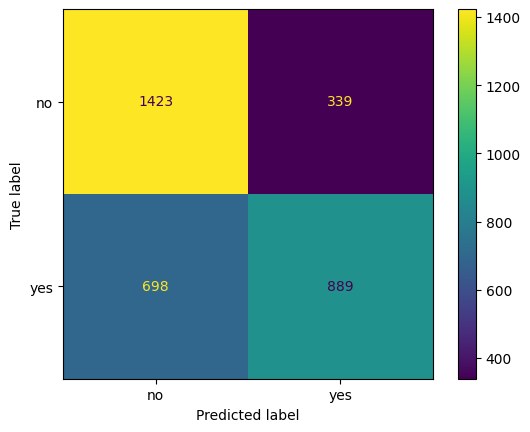

In [26]:
from sklearn.ensemble import RandomForestClassifier

# We choose our model.
forest = RandomForestClassifier (n_estimators = 100, max_depth = 5, random_state = 42)
forest.fit (Xtrain, ytrain.to_numpy ().ravel())

# We get our prediction.
ypred = forest.predict (Xtest)

# We show the scores.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()


##### 1.3.6. Random Forest.

Accuracy score:    0.6903553299492385
Precision score:   0.7239413680781759
Recall score:      0.5601764335223692
f1 score:          0.6316163410301954


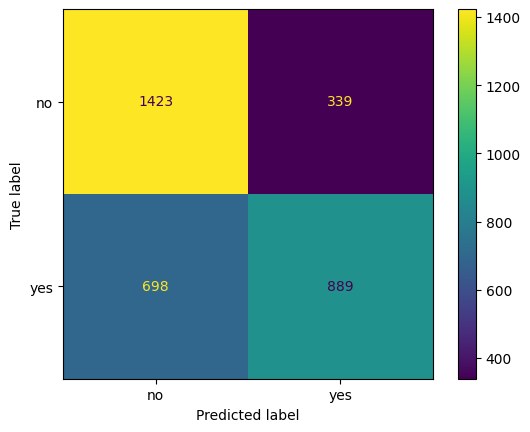

In [27]:
from sklearn.ensemble import RandomForestClassifier

# We choose our model.
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

forest.fit (Xtrain, ytrain.to_numpy ().ravel())

# We get our prediction.
ypred = forest.predict (Xtest)

# We show the scores.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# We show the confusion matrix.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

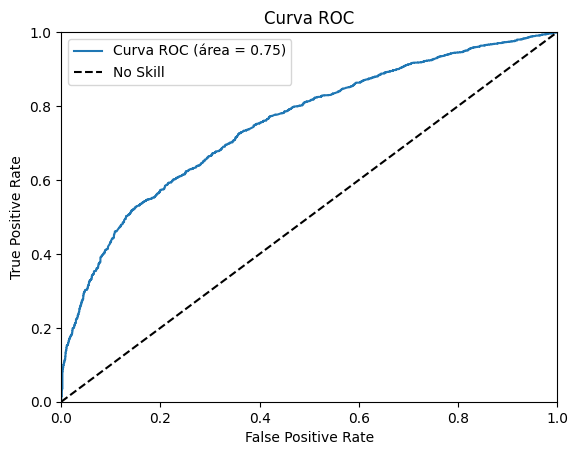

In [28]:
# We plot the 'ROC' curve.

yproba = forest.predict_proba (Xtest)

# We compute the curve values.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc(fpr, tpr)

# We plot the curve.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()
